In [1]:
# If you run this notebook on Google Colaboratory, uncomment the below to install automl_alex.
#!pip install -U -q automl-alex

In [1]:
import pandas as pd
import numpy as np
import sklearn
import automl_alex
import json
from automl_alex import BestSingleModelClassifier

In [2]:
print(automl_alex.__version__)

0.11.24


In [3]:
RANDOM_SEED = 42

# Classifier

## Data

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
dataset = fetch_openml(name='credit-g', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes
dataset.data.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                    dataset.target,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((800, 20), (200, 20))

## Model

In [6]:
model = BestSingleModelClassifier(X_train, y_train, X_test, random_state=RANDOM_SEED)

In [7]:
history = model.opt(timeout=1000, verbose=1)

One iteration takes ~ 3.2 sec
> Start Auto calibration parameters
[I 2020-11-23 14:38:22,492] A new study created in memory with name: no-name-45247feb-994a-46a6-ae21-c9604bef0640
> Start optimization with the parameters:
CV_Folds =  10
Score_CV_Folds =  3
Feature_Selection =  True
Opt_lvl =  2
Cold_start =  20.0
Early_stoping =  100
Metric =  roc_auc_score
Direction =  maximize
##################################################
Default model OptScore = 0.6574
Optimize: : 271it [06:19,  1.14s/it,  | Model: LinearModel | OptScore: 0.768 | Best roc_auc_score: 0.7873 +- 0.019269]
 EarlyStopping Exceeded: Best Score: 0.768 roc_auc_score
Optimize: : 271it [06:19,  1.40s/it,  | Model: LinearModel | OptScore: 0.768 | Best roc_auc_score: 0.7873 +- 0.019269]


In [8]:
model.history_trials_dataframe.head(5)

,score_opt,model_score,score_std,model_name,model_param,wrapper_params,cat_encoders,columns,cv_folds
169,0.7680,0.7873,0.019269,LinearModel,"{'fit_intercept': True, 'C': 75.1104945590015,...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","(OneHotEncoder_housing_3, OneHotEncoder_credit...",10
226,0.7664,0.7876,0.021219,LinearModel,"{'fit_intercept': True, 'C': 13.59023095309521...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","(OneHotEncoder_housing_3, OneHotEncoder_credit...",10
130,0.7662,0.7758,0.009626,MLP,"{'verbose': 0, 'random_state': 42, 'max_iter':...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","(OneHotEncoder_housing_1, OneHotEncoder_housin...",10
247,0.7661,0.7878,0.021671,LinearModel,"{'fit_intercept': True, 'C': 16.30300999930395...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","(OneHotEncoder_housing_3, OneHotEncoder_credit...",10
214,0.7660,0.7871,0.021071,LinearModel,"{'fit_intercept': True, 'C': 20.01505637206522...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","(OneHotEncoder_housing_3, OneHotEncoder_credit...",10


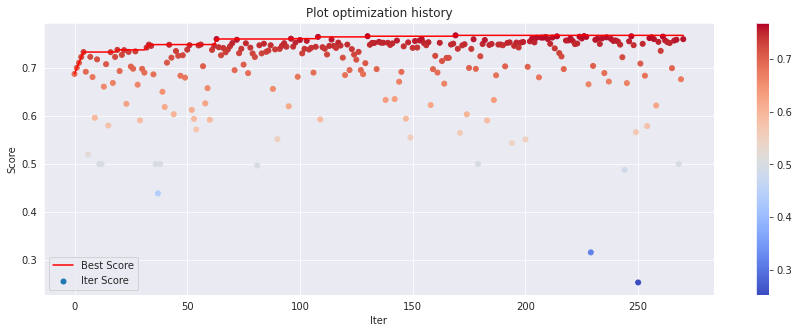

In [9]:
model.plot_opt_history()

In [10]:
predicts = model.predict()
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts['predict_test'][0]),4))

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
 Mean Score roc_auc_score on 20 Folds: 0.7713 std: 0.058559
Test AUC:  0.8289

